<a href="https://colab.research.google.com/github/yslk327/Flood_Map_Metrics/blob/main/Copie_de_MD_RF_classifier_Sentinel_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Installer les bibliothèques nécessaires
!pip install earthengine-api geemap
!pip install pandas
!pip install rasterio
!pip install numpy
#pip install --upgrade geemap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 25.0 MB/s eta 0:00:00


In [ ]:

# Importer les bibliothèques

import ee
import geemap
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from google.colab import drive
import rasterio

# Authentification Earth Engine
ee.Authenticate()  # Suivez les étapes pour autoriser votre compte
ee.Initialize(project='ee-yassineloukili')


In [ ]:
# Monter Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Charger la collection Sentinel-2 L1C
s2_L2A = ee.ImageCollection("COPERNICUS/S2_HARMONIZED")

# Charger les données de l'image et des échantillons : Tetouan-Morocco

geometry_area = ee.FeatureCollection("projects/ee-yassineloukili/assets/AnalysisExtent_Tetouan")  #  zone d'étude Tetouan_Morocco
#geometry_area = ee.FeatureCollection("projects/ee-yassineloukili/assets/extent_Tetouan")  #  zone d'étude Tetouan_Morocco
water_extent_area = ee.FeatureCollection("projects/ee-yassineloukili/assets/water_Extent_Tetouan")  #  zone inondé Tetouan_Morocco
other_data = ee.FeatureCollection("projects/ee-yassineloukili/assets/other_data_tetouan_400")  # échantillon d'entraînement autre Tetouan_Morocco
water_data = ee.FeatureCollection("projects/ee-yassineloukili/assets/water_data2_tetouan_400")  # échantillon d'entraînement eau Tetouan_Morocco
#water_data = ee.FeatureCollection("projects/ee-yassineloukili/assets/water_data_tetouan_100")  # échantillon d'entraînement eau Tetouan_Morocco

# Filtrer les images avant la période d'intérêt
image_before1 = s2_L2A.filterBounds(geometry_area).filterDate('2021-01-01', '2021-01-11')  # morocco
# Filtrer les images après la période d'intérêt
image_after1 = s2_L2A.filterBounds(geometry_area).filterDate('2021-01-12', '2021-01-18')  # morocco

# Charger les données de l'image et des échantillons : Matam-Senegal
"""
geometry_area = ee.FeatureCollection("projects/ee-yassineloukili/assets/AnalysisExtent_Matam_Senegal_20241025")  #  zone d'étude Matam_Senegal
water_extent_area = ee.FeatureCollection("projects/ee-yassineloukili/assets/water_Extent_Matam_Senegal_20241025")  #  zone inondé Matam_Senegal
other_data = ee.FeatureCollection("projects/ee-yassineloukili/assets/other_data_Senegal_400")  # échantillon d'entraînement autre Matam_Senegal
water_data = ee.FeatureCollection("projects/ee-yassineloukili/assets/water_data_Senegal_400")  # échantillon d'entraînement eau Matam_Senegal

# Filtrer les images avant la période d'intérêt
image_before1 = s2_L2A.filterBounds(geometry_area).filterDate('2024-10-20', '2024-10-24')  # Sénégal
# Filtrer les images après la période d'intérêt
image_after1 = s2_L2A.filterBounds(geometry_area).filterDate('2024-10-25', '2024-10-30')  # Sénégal
"""

# Trier par pourcentage de pixels nuageux et ajouter les métadonnées
image_before = image_before1.sort('CLOUDY_PIXEL_PERCENTAGE', False).map(lambda image: image.addBands(image.metadata('system:time_start'))).mosaic()
# Trier par pourcentage de pixels nuageux et ajouter les métadonnées
image_after = image_after1.sort('CLOUDY_PIXEL_PERCENTAGE', False).map(lambda image: image.addBands(image.metadata('system:time_start'))).mosaic()

# Sélectionner les bandes vertes (B3) et NIR (B8)
image_before_b = image_before1.select(['B3', 'B8'])
image_after_b = image_after1.select(['B3', 'B8'])

# Fonction pour calculer l'indice NDWI
def calculate_ndwi(img):
    ndwi = img.normalizedDifference(['B3', 'B8']).rename('NDWI')
    return img.addBands(ndwi)

# Appliquer la fonction NDWI à chaque image dans la collection
ndwi_after = image_after_b.map(calculate_ndwi)
ndwi_before = image_before_b.map(calculate_ndwi)

# Combiner toutes les données en une seule collection d'images
allcollection = ee.ImageCollection(ndwi_before.merge(ndwi_after)).mosaic().clip(geometry_area)

# Sélectionner les bandes à utiliser dans le classificateur
print("Bands in the merged collection:", allcollection.bandNames().getInfo())
bandNamesS2 = allcollection.bandNames()
print("Band names in allcollection:", bandNamesS2.getInfo())

Bands in the merged collection: ['B3', 'B8', 'NDWI']
Band names in allcollection: ['B3', 'B8', 'NDWI']


In [ ]:
merge_col=water_data.merge(other_data);
print('Merge collection',merge_col.size().getInfo());

# Extraire des échantillons d'entraînement depuis allcollection
Sample_LS = allcollection.sampleRegions(
    collection=merge_col,           # Collection d'échantillons d'entraînement
    properties=["land_class"],      # Propriété indiquant les classes (étiquettes)
    scale=10                        # Résolution spatiale (30m pour Landsat)
)

# Vérifiez la structure de Sample_LS
print("Sample_LS size:", Sample_LS.size().getInfo())

Merge collection 800
Sample_LS size: 800


In [ ]:
# Ajouter une colonne aléatoire
samples_with_random = Sample_LS.randomColumn()

# Diviser les échantillons : 70% pour l'entraînement, 30% pour la validation
training_samples = samples_with_random.filter(ee.Filter.gte("random", 0.3))
validation_samples = samples_with_random.filter(ee.Filter.lt("random", 0.3))

# Afficher la taille des ensembles
print("Nombre d'échantillons d'entraînement :", training_samples.size().getInfo())
print("Nombre d'échantillons de validation :", validation_samples.size().getInfo())

# Compter le nombre d'échantillons pour chaque classe dans l'échantillon d'entraînement
training_class_counts = training_samples.aggregate_histogram('land_class')
training_class_counts_dict = training_class_counts.getInfo()
print("Distribution des classes dans l'échantillon d'entraînement :")
for land_class, count in training_class_counts_dict.items():
    print(f"Classe {land_class}: {count}")

# Compter le nombre d'échantillons pour chaque classe dans l'échantillon de validation
validation_class_counts = validation_samples.aggregate_histogram('land_class')
validation_class_counts_dict = validation_class_counts.getInfo()
print("Distribution des classes dans l'échantillon de validation :")
for land_class, count in validation_class_counts_dict.items():
    print(f"Classe {land_class}: {count}")


Nombre d'échantillons d'entraînement : 552
Nombre d'échantillons de validation : 248
Distribution des classes dans l'échantillon d'entraînement :
Classe 0: 265
Classe 1: 287
Distribution des classes dans l'échantillon de validation :
Classe 0: 135
Classe 1: 113


In [ ]:
# Entraîner un classificateur smileRandomForest
RF_classifier_ts = ee.Classifier.smileRandomForest(50).train(
    features=training_samples,       # Ensemble d'entraînement
    classProperty="land_class",      # Colonne des classes
    inputProperties=bandNamesS2   # Noms des bandes
)

# Classifier les échantillons de validation
classified_validation_RF = validation_samples.classify(RF_classifier_ts)

# Calculer la matrice de confusion
confusion_matrix = classified_validation_RF.errorMatrix("land_class", "classification")

# Calculer les métriques d'évaluation
overall_accuracy = confusion_matrix.accuracy().getInfo()
user_accuracy = confusion_matrix.consumersAccuracy().getInfo()
producers_accuracy = confusion_matrix.producersAccuracy().getInfo()
kappa = confusion_matrix.kappa().getInfo()

print("Classificateur smileRandomForest:")
print("Confusion Matrix:", confusion_matrix.getInfo())
print("User Accuracy:", user_accuracy)
print("Producers Accuracy:", producers_accuracy)
print("Overall Accuracy:", overall_accuracy)
print("Kappa Coefficient:", kappa)


Classificateur smileRandomForest:
Confusion Matrix: [[135, 0], [3, 110]]
User Accuracy: [[0.9782608695652174, 1]]
Producers Accuracy: [[1], [0.9734513274336283]]
Overall Accuracy: 0.9879032258064516
Kappa Coefficient: 0.9755616870319275


In [ ]:
# Entraîner un classificateur minimumDistance
MD_classifier_ts = ee.Classifier.minimumDistance().train(
    features=training_samples,       # Ensemble d'entraînement
    classProperty="land_class",      # Colonne des classes
    inputProperties=bandNamesS2   # Noms des bandes
)

# Classifier les échantillons de validation
classified_validation_MD = validation_samples.classify(MD_classifier_ts)

# Calculer la matrice de confusion
confusion_matrix = classified_validation_MD.errorMatrix("land_class", "classification")

# Calculer les métriques d'évaluation
overall_accuracy = confusion_matrix.accuracy().getInfo()
user_accuracy = confusion_matrix.consumersAccuracy().getInfo()
producers_accuracy = confusion_matrix.producersAccuracy().getInfo()
kappa = confusion_matrix.kappa().getInfo()

print("Classificateur minimumDistance:")
print("Confusion Matrix:", confusion_matrix.getInfo())
print("User Accuracy:", user_accuracy)
print("Producers Accuracy:", producers_accuracy)
print("Overall Accuracy:", overall_accuracy)
print("Kappa Coefficient:", kappa)


Classificateur minimumDistance:
Confusion Matrix: [[99, 36], [0, 113]]
User Accuracy: [[1, 0.7583892617449665]]
Producers Accuracy: [[0.7333333333333333], [1]]
Overall Accuracy: 0.8548387096774194
Kappa Coefficient: 0.7147786083956297


In [ ]:
# Ajouter les prédictions des classificateurs aux échantillons de validation
classified_validation_MD = classified_validation_MD.map(
    lambda feature: feature.set({"MD_prediction": feature.get("classification")})
)

classified_validation_RF = classified_validation_RF.map(
    lambda feature: feature.set({"RF_prediction": feature.get("classification")})
)

# Fusionner les résultats pour inclure les prédictions MD et RF
classified_validation = classified_validation_RF.map(
    lambda feature: feature.set({
        "MD_prediction": classified_validation_MD.filter(
            ee.Filter.eq("system:index", feature.get("system:index"))
        ).first().get("MD_prediction")
    })
)

# Collecte des échantillons avec leurs étiquettes et prédictions
results = classified_validation

# Convertir les données en format Python avec une barre de progression
def feature_collection_to_dataframe_with_progress(feature_collection):
    """Convert a GEE FeatureCollection to a pandas DataFrame avec barre de progression."""
    # Obtenez les informations des fonctionnalités
    features_list = feature_collection.toList(feature_collection.size()).getInfo()  # Liste d'entités GEE
    rows = []

    # Initialiser la barre de progression
    for feature in tqdm(features_list, desc="Traitement des fonctionnalités"):
        rows.append(feature["properties"])

    return pd.DataFrame(rows)

# Télécharger les résultats avec barre de progression
print("Conversion des résultats...")
results_df = feature_collection_to_dataframe_with_progress(results)

print("Collecte des données terminée !!!")


Conversion des résultats...


Traitement des fonctionnalités: 100%|██████████| 248/248 [00:00<00:00, 191845.70it/s]

Collecte des données terminée !!!


Valeur de l'AUC :
Random Forest (RF): 0.99
Minimum Distance (MD): 0.87

Points de la courbe ROC pour RF:
Threshold: inf, FPR: 0.00, TPR: 0.00
Threshold: 1.00, FPR: 0.00, TPR: 0.97
Threshold: 0.00, FPR: 1.00, TPR: 1.00

Points de la courbe ROC pour MD:
Threshold: inf, FPR: 0.00, TPR: 0.00
Threshold: 1.00, FPR: 0.27, TPR: 1.00
Threshold: 0.00, FPR: 1.00, TPR: 1.00


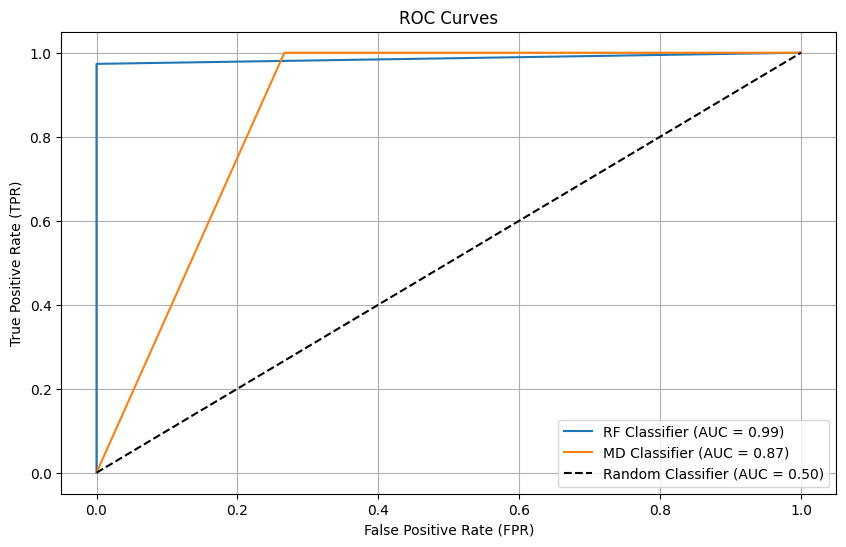

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

# Colonnes contenant les étiquettes réelles et les prédictions
true_labels = results_df["land_class"]  # Étiquettes réelles (0 ou 1 pour l'inondation)
rf_predictions = results_df["RF_prediction"]  # Prédictions RF
md_predictions = results_df["MD_prediction"]  # Prédictions MD

# Calculer les courbes ROC et les AUC pour RF
fpr_rf, tpr_rf, thresholds_rf = roc_curve(true_labels, rf_predictions)
auc_rf = roc_auc_score(true_labels, rf_predictions)

# Calculer les courbes ROC et les AUC pour MD
fpr_md, tpr_md, thresholds_md = roc_curve(true_labels, md_predictions)
auc_md = roc_auc_score(true_labels, md_predictions)

# Afficher les valeurs de AUC
print("Valeur de l'AUC :")
print(f"Random Forest (RF): {auc_rf:.2f}")
print(f"Minimum Distance (MD): {auc_md:.2f}")

# Afficher les points de la courbe ROC (FPR, TPR et thresholds)
print("\nPoints de la courbe ROC pour RF:")
for fpr, tpr, threshold in zip(fpr_rf, tpr_rf, thresholds_rf):
    print(f"Threshold: {threshold:.2f}, FPR: {fpr:.2f}, TPR: {tpr:.2f}")

print("\nPoints de la courbe ROC pour MD:")
for fpr, tpr, threshold in zip(fpr_md, tpr_md, thresholds_md):
    print(f"Threshold: {threshold:.2f}, FPR: {fpr:.2f}, TPR: {tpr:.2f}")

# Tracer les courbes ROC
plt.figure(figsize=(10, 6))
plt.plot(fpr_rf, tpr_rf, label=f"RF Classifier (AUC = {auc_rf:.2f})")
plt.plot(fpr_md, tpr_md, label=f"MD Classifier (AUC = {auc_md:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier (AUC = 0.50)")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curves")
plt.legend(loc="best")
plt.grid()
plt.show()


In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, balanced_accuracy_score


# Préparer les données (à adapter selon votre dataset)
# Charger les échantillons de validation depuis votre script
Sample_LS_DATA = Sample_LS.getInfo()  # Assurez-vous que validation_samples est déjà défini
data = Sample_LS_DATA ["features"]
data = pd.DataFrame([feat["properties"] for feat in data])
X = data[["B3", "B8", "NDWI"]]  # Colonnes des caractéristiques
y = data["land_class"]               # Colonne cible

# Définir la validation croisée stratifiée
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialiser les listes pour stocker les résultats
f1_scores_rf = []
balanced_accuracies_rf = []

f1_scores_md = []
balanced_accuracies_md = []

# Boucle sur chaque fold
for train_index, test_index in kfold.split(X, y):
    # Diviser les données en ensembles d'entraînement et de test
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # 1. Random Forest Classifier
    from sklearn.ensemble import RandomForestClassifier
    rf_model = RandomForestClassifier(random_state=42)
    rf_model.fit(X_train, y_train)
    y_pred_rf = rf_model.predict(X_test)

    # Calculer les métriques
    f1_scores_rf.append(f1_score(y_test, y_pred_rf))
    balanced_accuracies_rf.append(balanced_accuracy_score(y_test, y_pred_rf))

    # 2. Minimum Distance Classifier
    from sklearn.neighbors import NearestCentroid
    md_model = NearestCentroid(metric='euclidean')  # Classifieur basé sur la distance minimale
    md_model.fit(X_train, y_train)
    y_pred_md = md_model.predict(X_test)

    # Calculer les métriques
    f1_scores_md.append(f1_score(y_test, y_pred_md))
    balanced_accuracies_md.append(balanced_accuracy_score(y_test, y_pred_md))

# Résultats finaux (moyennes et écarts-types)
print("Random Forest:")
print(f"F1-score: {np.mean(f1_scores_rf):.2f} ± {np.std(f1_scores_rf):.2f}")
print(f"Balanced Accuracy: {np.mean(balanced_accuracies_rf):.2f} ± {np.std(balanced_accuracies_rf):.2f}")

print("\nMinimum Distance:")
print(f"F1-score: {np.mean(f1_scores_md):.2f} ± {np.std(f1_scores_md):.2f}")
print(f"Balanced Accuracy: {np.mean(balanced_accuracies_md):.2f} ± {np.std(balanced_accuracies_md):.2f}")


Random Forest:
F1-score: 0.99 ± 0.01
Balanced Accuracy: 0.99 ± 0.01

Minimum Distance:
F1-score: 0.91 ± 0.02
Balanced Accuracy: 0.90 ± 0.03


In [ ]:
# Entraîner un classificateur
MD_classifier = ee.Classifier.minimumDistance().train(
    features=Sample_LS,  # Ensemble d'entraînement
    classProperty="land_class",  # Colonne des classes
    inputProperties=bandNamesS2   # Bandes utilisées
)
# Appliquer le classificateur
MD_classification= allcollection.classify(MD_classifier)

###########################################################################

RF_classifier = ee.Classifier.smileRandomForest(50).train(
    features=Sample_LS,  # Ensemble d'entraînement
    classProperty="land_class",  # Colonne des classes
    inputProperties=bandNamesS2   # Bandes utilisées
)

# Appliquer le classificateur
RF_classification= allcollection.classify(RF_classifier)

combined_classification = RF_classification.eq(1).Or(MD_classification.eq(1))

# Calcul de l'aire des zones inondées
pixel_area_RF = RF_classification.multiply(ee.Image.pixelArea())
# Calcul de la surface totale inondée
total_flooded_area_RF = pixel_area_RF.reduceRegion(
    reducer=ee.Reducer.sum(),
    geometry=geometry_area,
    scale=10,
    maxPixels=1e13
)
# Convertir en hectares
flooded_area_ha_RF = ee.Number(total_flooded_area_RF.get("classification")).divide(10000)
print("Étendue totale de la surface d'eau détecté (ha)-RF:", flooded_area_ha_RF.getInfo())

###########################################################################################
pixel_area_MD = MD_classification.multiply(ee.Image.pixelArea())
# Calcul de la surface totale inondée
total_flooded_area_MD = pixel_area_MD.reduceRegion(
    reducer=ee.Reducer.sum(),
    geometry=geometry_area,
    scale=10,
    maxPixels=1e13
)
# Convertir en hectares
flooded_area_ha_MD = ee.Number(total_flooded_area_MD.get("classification")).divide(10000)
print("Étendue totale de la surface d'eau détecté (ha)-MD:", flooded_area_ha_MD.getInfo())


###########################################################################################
pixel_area = combined_classification.multiply(ee.Image.pixelArea())
# Calcul de la surface totale inondée
total_flooded_area = pixel_area.reduceRegion(
    reducer=ee.Reducer.sum(),
    geometry=geometry_area,
    scale=10,
    maxPixels=1e13
)
# Convertir en hectares
flooded_area_ha = ee.Number(total_flooded_area.get("classification")).divide(10000)
print("Étendue totale de la surface d'eau détecté (ha)-RF & MD :", flooded_area_ha.getInfo())

################################################# Extent permanentWater ###################
#the Copernicus Global Land Service (CGLS) land cover map (100m)
CGLS=ee.Image("COPERNICUS/Landcover/100m/Proba-V-C3/Global/2019")
landcover = CGLS.select('discrete_classification')
landcover_area = landcover.clip(geometry_area)

#Extract only water pixels from CGLS using class value equal to 80 or 200
water = landcover_area.eq(80).Or(landcover_area.eq(200))

#extent permanentWater
inundation_area_PW = water.multiply(ee.Image.pixelArea())

# Sum the area covered by inundated pixels.
inundation_stats_PW = inundation_area_PW.reduceRegion (
   reducer= ee.Reducer.sum(),
   geometry= geometry_area,
   scale= 10,
   maxPixels= 1e13,
   bestEffort= True
  )
# Convertir PW en hectares
PW_area_ha = ee.Number(inundation_stats_PW.get("discrete_classification")).divide(10000)
print("Étendue de l'eau permanente (ha) :", PW_area_ha.getInfo())
###############################################################################################
#surface totale inondée
surf_total_RF=flooded_area_ha_RF.subtract(PW_area_ha)
print("Surface totale de l'inondation (ha)-RF :", surf_total_RF.getInfo())
surf_total_MD=flooded_area_ha_MD.subtract(PW_area_ha)
print("Surface totale de l'inondation (ha)-MD :", surf_total_MD.getInfo())
surf_total=flooded_area_ha.subtract(PW_area_ha)
print("Surface totale de l'inondation (ha)-RF & MD :", surf_total.getInfo())


Étendue totale de la surface d'eau détecté (ha)-RF: 157.9471616219255
Étendue totale de la surface d'eau détecté (ha)-MD: 636.1257762677448
Étendue totale de la surface d'eau détecté (ha)-RF & MD : 636.1257762677448
Étendue de l'eau permanente (ha) : 153.64820398822255
Surface totale de l'inondation (ha)-RF : 4.2989576337029405
Surface totale de l'inondation (ha)-MD : 482.4775722795222
Surface totale de l'inondation (ha)-RF & MD : 482.4775722795222


In [ ]:
# Calculer les aires en mètres carrés pour chaque entité et ajouter en tant que propriété
water_extent_area_with_area = water_extent_area.map(lambda feature:
    feature.set({'area_m2': feature.geometry().area()}))

# Extraire la somme des aires
total_area_m2 = water_extent_area_with_area.aggregate_sum('area_m2')

# Convertir en hectares
total_area_ha = total_area_m2.divide(10000)

# Imprimer le résultat
print("Étendue totale en hectares :", total_area_ha.getInfo())

Area_Difference = total_area_ha.subtract(surf_total).abs()
print("Difference area :", Area_Difference.getInfo())


Étendue totale en hectares : 920.0451908595327
Difference area : 437.5676185800105


In [ ]:
# Définir la palette de couleurs pour les images en vraies couleurs
trueColor_sentinel2 = {
    'bands': ['B4', 'B3', 'B2'],
    'min': 0,
    'max': 3000
}
# Créer une carte et afficher les résultats
Map = geemap.Map()
Map.centerObject(geometry_area, 10)
# Ajouter les images avant et après à la carte
Map.addLayer(image_before, trueColor_sentinel2, 'before true color S2', 1)
Map.addLayer(image_after, trueColor_sentinel2, 'after true color S2', 0)

# Map.add_basemap("Esri.NatGeoWorldMap")
#Map.add_basemap("SATELLITE")
#Map.add_basemap("BaseMapDE.Color")

# Ajouter les zones inondées
Map.addLayer(water_extent_area, {}, "Zone Inondées unosat", 1)
# Ajouter les couches
Map.addLayer(combined_classification.updateMask(combined_classification), {'palette': 'red'}, 'Combined Flood', 0)
Map.addLayer(MD_classification.updateMask(MD_classification.eq(1)), {'palette': 'yellow'}, 'Minimum Distance Flood', 1)
Map.addLayer(RF_classification.updateMask(RF_classification.eq(1)), {'palette': 'green'}, 'Random Forest Flood', 1)
#Add reference data points into the map to visualize
Map.addLayer(water_data.draw("blue"),{},"water",1)
Map.addLayer(other_data.draw("red"),{},"other",1)

Map.addLayer(water.selfMask(), {'palette': 'blue'}, 'Permanent water', 1)
# Ajouter la zone d'étude
Map.addLayer(geometry_area, {}, "Study area", 1)
# Afficher la carte
#Map.to_html("map_senegal_matam_MD_RF_S2_400_water.html")
Map.to_html("map_tetouan_morocco_MD_RF_S2_400_water.html")
print("Carte enregistrée!")
Map

Carte enregistrée!


Map(center=[35.61212326806767, -5.295784828923017], controls=(WidgetControl(options=['position', 'transparent_…

In [ ]:

task = ee.batch.Export.image.toDrive(
    image=combined_classification,
    #description="classification_MD_RF_senegal_matam_S2_400pt_water",
    description="classification_MD_RF_tetouan_morocco_S2_400pt_water",
    folder="GEE_Exports",
    #fileNamePrefix="classification_Md_RF_senegal_matam_S2_400pt_water",
    fileNamePrefix="classification_Md_RF_tetouan_morocco_S2_400pt_water",
    region=geometry_area.geometry(),
    scale=10,
    crs='EPSG:4326',
    maxPixels=1e13
)
task.start()


**Calculate IoU,Overlap Percentage,Commission Error and Omission Errors**


In [ ]:
from osgeo import gdal

def align_rasters(reference_path, target_path, output_path):
    """Align the target raster to match the reference raster."""
    reference = gdal.Open(reference_path)
    target = gdal.Open(target_path)

    reference_proj = reference.GetProjection()
    reference_geotransform = reference.GetGeoTransform()
    x_res = reference.RasterXSize
    y_res = reference.RasterYSize

    driver = gdal.GetDriverByName("GTiff")
    aligned_target = driver.Create(
        output_path,
        x_res,
        y_res,
        1,
        gdal.GDT_Int32
    )

    aligned_target.SetGeoTransform(reference_geotransform)
    aligned_target.SetProjection(reference_proj)

    gdal.ReprojectImage(
        target,
        aligned_target,
        target.GetProjection(),
        reference_proj,
        gdal.GRA_NearestNeighbour
    )
    aligned_target.FlushCache()

def calculate_metrics(reference_path, aligned_target_path):
    """Calculate intersection, union, IoU, overlap percentage, commission error, and omission error."""
    with rasterio.open(reference_path) as ref_src:
        ref_array = ref_src.read(1)
        ref_array = np.where(ref_array == ref_src.nodata, 0, ref_array)
        ref_array = np.where(ref_array == 1, 1, 0)  # Binary water mask

    with rasterio.open(aligned_target_path) as tgt_src:
        tgt_array = tgt_src.read(1)
        tgt_array = np.where(tgt_array == tgt_src.nodata, 0, tgt_array)
        tgt_array = np.where(tgt_array == 1, 1, 0)  # Binary water mask

        print(f"Benchmark map: {ref_array.sum()}")
        print(f"Prediction map: {tgt_array.sum()}")

    # Calculate Intersection and Union
    intersection = np.logical_and(ref_array, tgt_array).sum()
    union = np.logical_or(ref_array, tgt_array).sum()

    # IoU Calculation
    iou = (intersection / union) * 100 if union != 0 else 0

    # Overlap Percentage Calculation
    overlap_percentage = (intersection / ref_array.sum()) * 100 if ref_array.sum() != 0 else 0

    # Commission Error: False Positives / (True Positives + False Positives)
    false_positives = np.logical_and(tgt_array == 1, ref_array == 0).sum()
    true_positives = intersection
    commission_error = false_positives / (true_positives + false_positives) if (true_positives + false_positives) != 0 else 0

    # Omission Error: False Negatives / (True Positives + False Negatives)
    false_negatives = np.logical_and(tgt_array == 0, ref_array == 1).sum()
    omission_error = false_negatives / (true_positives + false_negatives) if (true_positives + false_negatives) != 0 else 0

    return intersection, union, iou, overlap_percentage, commission_error, omission_error

# File paths
#benchmark_map_path = "/content/drive/MyDrive/GEE_Exports/WaterExtent_S2_MatamDepartment_PolygonToRaster.tif"
#predicted_map_path = "/content/drive/MyDrive/GEE_Exports/SENTINEL-2/classification_Md_RF_senegal_matam_S2_400pt_water.tif"
#aligned_predicted_path = "/content/drive/MyDrive/GEE_Exports/SENTINEL-2/aligned_predicted_Md_RF_senegal_matam_S2_400pt_water.tif"


benchmark_map_path = '/content/drive/MyDrive/GEE_Exports/WaterExtent_MatamDepartment_PolygonToRaster_20241025.tif'
predicted_map_path = '/content/drive/MyDrive/GEE_Exports/SENTINEL-2/classification_Md_RF_tetouan_morocco_S2_400pt_water.tif'
aligned_predicted_path = "/content/drive/MyDrive/GEE_Exports/SENTINEL-2/aligned_predicted_Md_RF_tetouan_morocco_S2_400pt_water.tif"


# Step 1: Align rasters
align_rasters(benchmark_map_path, predicted_map_path, aligned_predicted_path)

# Step 2: Calculate metrics
intersection, union, iou, overlap_percentage, commission_error, omission_error = calculate_metrics(benchmark_map_path, aligned_predicted_path)

# Step 3: Print results
print("Metrics:")
print(f"Intersection: {intersection}")
print(f"Union: {union}")
print(f"IoU: {iou:.2f}%")
print(f"Overlap Percentage: {overlap_percentage:.2f}%")
print(f"Commission Error: {commission_error * 100:.2f}%")
print(f"Omission Error: {omission_error * 100:.2f}%")


Benchmark map: 45199109
Prediction map: 30391587
Metrics:
Intersection: 25138647
Union: 50452049
IoU: 49.83%
Overlap Percentage: 55.62%
Commission Error: 17.28%
Omission Error: 44.38%


**Overlap Percentage with ArcGis**

In [ ]:
#intersected_Area_s1_tetouan= ; #from .tif in Arcgis;
#intersected_Area_s1_matam= ; #from .tif in Arcgis;

#intersected_Area_s2_tetouan_400pt=8398; #from .tif in Arcgis;
intersected_Area_s2_matam_100pt = 3783250; #from .tif in Arcgis;
Union_Area_s2_matam_100pt = 	4855560; #from .tif in Arcgis;

#intersected_Area_ls_tetouan=; #from .tif in Arcgis ;
#intersected_Area_ls_matam=; #from .tif in Arcgis ;


matam_Flood_area_unosat=	4787251;
#tetouan_Flood_area_unosat=8790;



#Overlap_Percentage_s1=(intersected_Area_s1/Flood_area_arc)*100;
#print(f"Overlap Percentage sentinel-1:{Overlap_Percentage_s1:.2f}");

#Overlap_Percentage_ls=(intersected_Area_ls/Flood_area_arc)*100;
#print(f"Overlap Percentage landsat:{Overlap_Percentage_ls:.2f}");

#Overlap_Percentage_s2=(intersected_Area_s2_tetouan_400pt/tetouan_Flood_area_unosat)*100;
#print(f"Overlap Percentage sentinel-2:{Overlap_Percentage_s2:.2f}%");

Overlap_Percentage_s2=(intersected_Area_s2_matam_100pt/matam_Flood_area_unosat)*100;
print(f"Overlap Percentage sentinel-2:{Overlap_Percentage_s2:.2f}%");

iou = (intersected_Area_s2_matam_100pt / Union_Area_s2_matam_100pt) * 100
print(f"IoU: {iou:.2f}%")





Overlap Percentage sentinel-2:79.03%
IoU: 77.92%
